# Latency is Lognormal-ish

This is notebook contains a section I cut from *[Probably Overthinking It: How to Use Data to Answer Questions, Avoid Statistical Traps, and Make Better Decisions](https://greenteapress.com/wp/probably-overthinking-it)*, University of Chicago Press, 2023.

It presents a possible explanation for the observation that the latency period for some infectious diseases follows something like a lognormal distribution, as does the survival time for some cancers.

Both cases can be modeled by a biased random walk -- in this model, the log time to reach some threshold is approximated by a conjugate Gaussian distribution.
So it's not really lognormal, but it can often be approximated by a lognormal.

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Install empiricaldist if we don't already have it

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

<IPython.core.display.Javascript object>

In [3]:
# download utils.py

from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download(
    "https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/notebooks/utils.py"
)

<IPython.core.display.Javascript object>

In [4]:
from utils import decorate

<IPython.core.display.Javascript object>

In [5]:
from empiricaldist import Cdf
from scipy.optimize import least_squares
from scipy.stats import norm


def fit_normal(series):
    """Find the model that minimizes the errors in percentiles."""

    def error_func(params, series):
        mu, sigma = params
        cdf = Cdf.from_seq(series)
        ps = np.linspace(0.01, 0.99)
        qs = series.quantile(ps)
        error = cdf(qs) - norm.cdf(qs, mu, sigma)
        return error

    params = series.mean(), series.std()
    res = least_squares(error_func, x0=params, args=(series,), ftol=1e3)
    assert res.success
    mu, sigma = res.x
    return norm(mu, sigma)

<IPython.core.display.Javascript object>

In [6]:
from scipy.stats import binom


def normal_error_bounds(dist, n, qs, alpha=0.95):
    """Find the bounds on a normal CDF analytically."""
    # find the correct probabilities
    ps = dist.cdf(qs)

    # find the upper and lower percentiles of
    # a binomial distribution
    p_low = (1 - alpha) / 2
    p_high = 1 - p_low

    low = binom.ppf(p_low, n, ps) / n
    low[ps == 1] = 1
    high = binom.ppf(p_high, n, ps) / n
    return low, high

<IPython.core.display.Javascript object>

In [7]:
from utils import make_cdf


def make_plot(series, model_label=None, plot_bounds=True, qs=None, **options):
    cdf = make_cdf(series)
    dist = fit_normal(series)
    p = 1 - (1 / len(series))
    upper = dist.ppf(p)

    if plot_bounds:
        plt.plot(upper, p * 100, "+", color="black", ms=12)

    n = len(series)
    if qs is None:
        q_max = max(cdf.qs.max(), upper)
        qs = np.linspace(cdf.qs.min(), q_max)
    low, high = normal_error_bounds(dist, n, qs)
    plt.fill_between(qs, low * 100, high * 100, color="gray", alpha=0.3)

    cdf.plot(**options)

<IPython.core.display.Javascript object>

## Infectious Disease Incubation

Early in the COVID-19 pandemic, a team of researchers in Ireland reviewed studies of the incubation time of the new virus.
They concluded that incubation times are well modeled by a lognormal distribution.

To see how well, I chose the largest dataset they found, which describes cases from early 2020 where the dates of exposure and the onset of symptoms are known with precision.
The dataset includes 1155 cases from China, Japan, Singapore, South Korea, Vietnam, Germany and Malaysia.
The following figure shows the distribution of the incubation periods and a lognormal model fit to the data.

In [8]:
DATA_PATH = "https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/data/"
filename = "ma2020.csv"
download(DATA_PATH + filename)

<IPython.core.display.Javascript object>

In [9]:
df = pd.read_csv(filename, header=None)

<IPython.core.display.Javascript object>

In [10]:
from collections import Counter

latency = pd.Series(Counter(df[3].to_dict()).elements())
len(latency)

1155

<IPython.core.display.Javascript object>

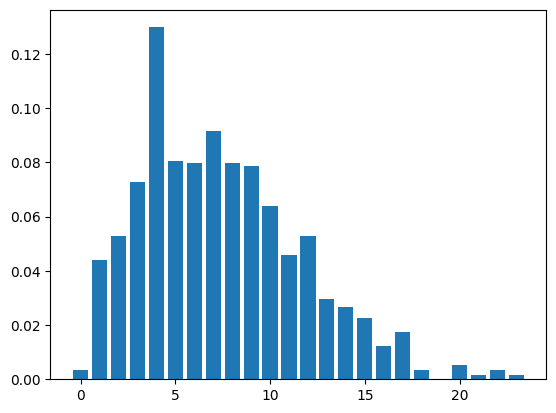

<IPython.core.display.Javascript object>

In [11]:
from empiricaldist import Pmf

Pmf.from_seq(latency).bar()

In [12]:
latency_jitter = latency.replace(0, 1) + np.random.uniform(0, 1, len(latency))

<IPython.core.display.Javascript object>

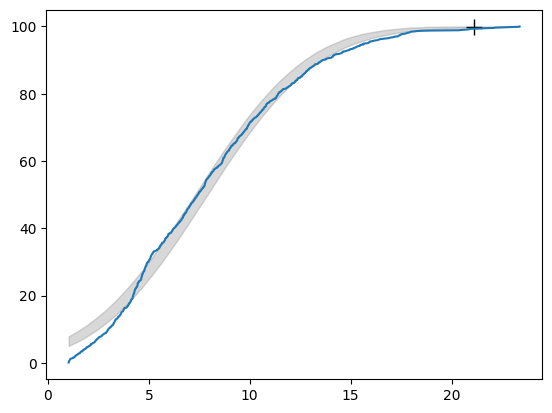

<IPython.core.display.Javascript object>

In [13]:
make_plot(latency_jitter)

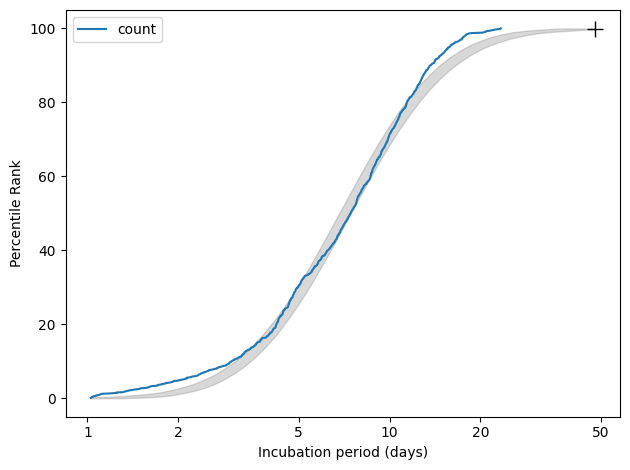

<IPython.core.display.Javascript object>

In [14]:
log_latency = np.log10(latency_jitter)
make_plot(log_latency)

labels = [1, 2, 5, 10, 20, 50]
ticks = np.log10(labels)
plt.xticks(ticks, labels)
decorate(xlabel="Incubation period (days)", ylabel="Percentile Rank")

This model might be good enough for practical purposes, but there are two notable discrepancies: there are more cases near two days than we would expect from a lognormal distribution, and fewer cases longer than 20 days.

At the low end, the data might deviate from the model because we don't know precisely when some patients were exposed or when they developed symptoms.
At the high end, the reason for the discrepancy might be that if someone has not developed symptoms after 20 days, they never do, so they don't appear in the dataset.

But it's also possible that the data do not actually follow a lognormal distribution.
To see why not, let's consider what happens when an infection occurs.

For an airborn virus like COVID, an aerosol droplet containing virus particles has to get past physical, chemical, and cellular defenses, contact the surface of a susceptible cell, and cross the cell membrane.
Once the virus infiltrates a cell, it uses the cell's replication mechanism to make copies of itself; eventually, these copies escape from the cell and go on to infect other cells.

At first the total number of copies, called the viral load, increases quickly.
However, almost immediately the primary immune response destroys some copies of the virus and the cells they infect. Later, as part of the secondary immune response, specific antibodies arrive that destroy the virus more effectively.

The workings of the immune system are famously complicated, but let me suggest a simple model.
Suppose that, after infection, viral load tends to increase over time, but at a varying rate. It might increase quickly during some periods, slowly during others, and it might even decrease sometimes.
If we consider the growth rate to be a random quantity, the viral load at a given point in time is the product of an initial value and a large number of random factors.
If reality is enough like this model, viral load at any point in time would tend to follow a lognormal distribution.

However, that doesn't explain the distribution of incubation times.
For that, we have to make one more assumption: suppose, for each person, there is some threshold of viral load that determines the onset of symptoms.
While viral load is below the threshold, the person is asymptomatic; when it exceeds the threshold, they start to feel sick.
With this assumption, we can simulate the infection process and see what the distribution of incubation periods looks like.

I should acknowledge that I am not completely making this up.
In a 2007 review article, the epidemiologist Hiroshi Nishiura summarizes efforts to model incubation times of infection disease: "What we have learnt to date can be described as follows: if the growth rate of a microorganism is implicitly assumed to follow normal distribution, and if there is a fixed threshold of pathogen load at which symptoms are revealed due to the host response, exponential growth of microorganisms should result in an incubation period sufficiently approximated by lognormal distribution."

Based on these assumptions, I wrote a simulation of 1155 people infected at the same time.
Each person has a random initial viral load between 1 and 10, and a random threshold near 100.
I divided each simulated day into 10 time steps.
During each time step, viral load increases (or sometimes decreases) by a growth factor chosen from a uniform distribution with a range chosen to fit the data.
The following figure shows the distribution of incubation times from the simulation along with the data.

In [15]:
from scipy.stats import norm

rows = 1155
cols = 1000
np.random.seed(18)

# rvs = norm.rvs(0, 1, size=(rows, cols))
rvs = np.random.uniform(-2, 2, size=(rows, cols))

start = np.random.uniform(1, 10, rows)
thresh = np.random.normal(100, 10, rows)

<IPython.core.display.Javascript object>

In [16]:
def simulate_latency(start, thresh, mu=1.1, sigma=0.1):
    factors = rvs * sigma + mu
    product = factors.cumprod(axis=1)
    load = start[:, None] * product
    times = np.argmax(load > thresh[:, None], axis=1)

    # make sure no rows started above the threshold and
    # all rows ran long enough to exceed the threshold
    assert np.all(times > 0)

    # The correlation between start and times tends to be weak,
    # with rho around 0.25
    # print(np.corrcoef(start, times))
    return pd.Series(times / 10)

<IPython.core.display.Javascript object>

In [17]:
mu = 1.06
sigma = 0.2

times = simulate_latency(start, thresh, mu, sigma)

<IPython.core.display.Javascript object>

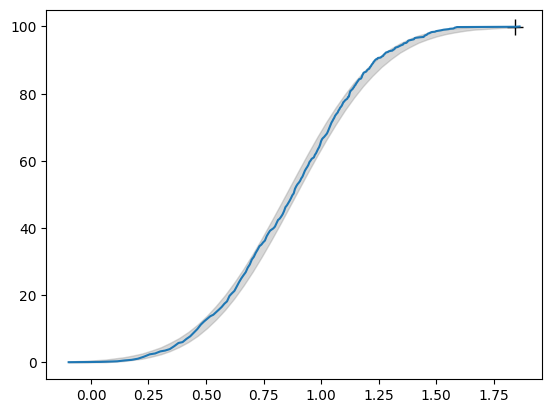

<IPython.core.display.Javascript object>

In [18]:
# the distribution of times from the simulation could pass for lognormal

make_plot(np.log10(times))

In [19]:
def error_func_latency(params, series):
    mu, sigma = params
    sim_latency = simulate_latency(start, thresh, mu, sigma)

    log_sim = np.log10(sim_latency)
    log_series = np.log10(series)

    cdf_sim = Cdf.from_seq(log_sim)
    cdf_series = Cdf.from_seq(log_series)

    # cdf_sim.plot(color="gray")
    # cdf_series.plot()

    # match the forward CDF
    qs = np.log10([1.5, 3, 6, 12, 15, 18])
    error = cdf_sim(qs) - cdf_series(qs)

    # match the inverse CDF
    ps = [0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95]
    # error = cdf_sim.inverse(ps) - cdf_series.inverse(ps)

    # match the mean and std
    # error = log_sim.mean() - log_series.mean(), log_sim.std() - log_series.std()

    return error

<IPython.core.display.Javascript object>

In [20]:
params = 1.06, 0.2
error_func_latency(params, latency_jitter)

array([-0.01904762,  0.01212121,  0.00865801, -0.07012987, -0.08398268,
       -0.07792208])

<IPython.core.display.Javascript object>

In [21]:
res = least_squares(
    error_func_latency, x0=params, diff_step=0.002, args=(latency_jitter,), xtol=1e-3
)
assert res.success
res.x

array([1.06500781, 0.20434182])

<IPython.core.display.Javascript object>

In [22]:
def plot_simulations():
    rows = 1155
    cols = 1000
    np.random.seed(18)

    for i in range(11):
        rvs = np.random.uniform(-2, 2, size=(rows, cols))
        start = np.random.uniform(1, 10, rows)
        thresh = np.random.normal(100, 10, rows)
        sim_latency = simulate_latency(start, thresh, *res.x)
        log_sim = np.log10(sim_latency)
        cdf_sim = Cdf.from_seq(log_sim) * 100
        label = "Simulation" if i == 0 else ""
        cdf_sim.plot(color="gray", alpha=0.05, label=label)

<IPython.core.display.Javascript object>

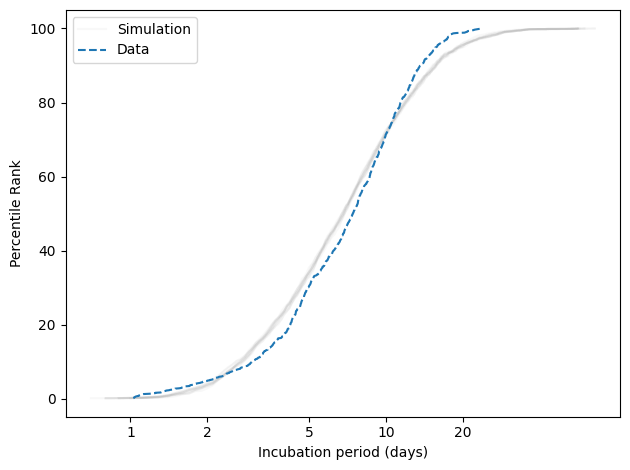

<IPython.core.display.Javascript object>

In [23]:
plot_simulations()
cdf_latency = Cdf.from_seq(log_latency) * 100
cdf_latency.plot(ls="--", label="Data")

labels = [1, 2, 5, 10, 20]
ticks = np.log10(labels)
plt.xticks(ticks, labels)
decorate(xlabel="Incubation period (days)", ylabel="Percentile Rank")

The simulation results fit the data better than the lognormal model in some places and less well in other places.
For practical purposes, there's probably no reason to prefer one model over the other.

But this example shows that the simulation generates results resemble the data, so that's a start.
Also, the model is robust in the sense that the results don't depend strongly on the assumptions we made. 
For example, we could change the distribution of start times, the distribution of thresholds, and the distribution of growth rates, and results would look about the same.

So this model might explain the distribution of incubation times:

* If each infection begins with a small viral load, and the growth rate varies randomly, we expect the distribution of viral load at any point in time to be lognormal.

* Furthermore, if symptoms begin when viral load exceeds some threshold, the distribution of incubation times will be approximately lognormal.

Using this model, we can derive a formula for the distribution, which turns out to be mathematically related to the Gaussian curve.
The following figure shows the results from the simulation again, along with the results from the formula.

In [24]:
#
#The following figure shows the values from this theoretical model along with the data.

#The theoretical model is consistent with the simulation, 
# which shows that the mathematical analysis is correct, and it fits the data well.


<IPython.core.display.Javascript object>

In [25]:
def make_conj_normal(m, s2, x):
    ts = np.linspace(5, 500, 100)
    ps = np.exp(-((x - ts * m) ** 2) / (2 * ts * s2)) / np.sqrt(ts * s2)
    pmf = Pmf(ps, ts / 10)
    pmf.normalize()
    cdf = pmf.make_cdf()
    return cdf

<IPython.core.display.Javascript object>

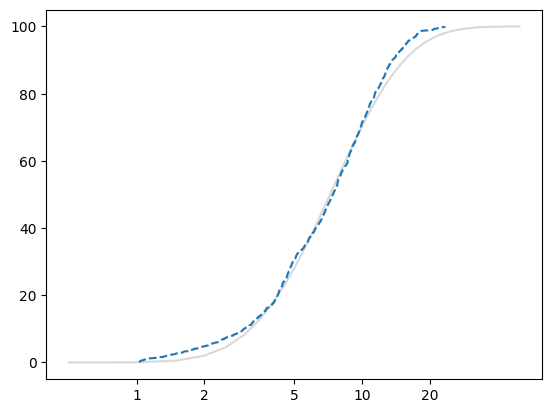

<IPython.core.display.Javascript object>

In [26]:
params = [0.04, 0.04, 2.5]
cdf_cn = make_conj_normal(*params)

cdf_log_cn = cdf_cn.transform(np.log10) * 100
cdf_log_cn.plot(color="gray", alpha=0.3)
cdf_latency.plot(ls="--", label="Data")

labels = [1, 2, 5, 10, 20]
ticks = np.log10(labels)
plt.xticks(ticks, labels)
None

In [27]:
def error_func_conj_normal(params, series):
    print(params)
    cdf_cn = make_conj_normal(*params)
    cdf_log_cn = cdf_cn.transform(np.log10)

    log_series = np.log10(series)
    cdf_series = Cdf.from_seq(log_series)

    # match the forward CDF
    qs = np.log10([1.5, 3, 6, 9, 12, 15, 18])
    # error = cdf_log_cn(qs) - cdf_series(qs)

    # match the inverse CDF
    # ps = [0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95]
    ps = np.linspace(0.05, 0.95)
    error = cdf_log_cn.inverse(ps) - cdf_series.inverse(ps)

    # match the mean and std
    # error = cdf_log_cn.mean() - log_series.mean(), cdf_log_cn.std() - log_series.std()

    return error

<IPython.core.display.Javascript object>

In [28]:
error_func_conj_normal(params, latency_jitter)

[0.04, 0.04, 2.5]


array([ 0.16618714,  0.09552093,  0.09509527,  0.05482109,  0.0246948 ,
        0.0480674 ,  0.02492526,  0.04296594,  0.02864981,  0.01938761,
        0.05130712,  0.03276165,  0.02333986,  0.05246062,  0.03721056,
        0.02518023,  0.0352362 ,  0.01646399,  0.00280676,  0.01807318,
       -0.00122836,  0.01834984,  0.00712251, -0.00617542,  0.01018412,
       -0.00296315,  0.01261373,  0.00695176, -0.00506023,  0.00487723,
       -0.00783934,  0.00965257, -0.00121868,  0.00942187,  0.01998088,
        0.0084642 ,  0.02214646,  0.00783942,  0.01705229,  0.02660427,
        0.02725391,  0.03744546,  0.03724656,  0.03963661,  0.04245988,
        0.04654151,  0.06007667,  0.06635815,  0.06779003,  0.07811403])

<IPython.core.display.Javascript object>

In [29]:
res2 = least_squares(
    error_func_conj_normal,
    x0=params,
    diff_step=0.002,
    args=(latency_jitter,),
    xtol=1e-3,
)
assert res2.success
res2.x

[0.04 0.04 2.5 ]
[0.04008 0.04    2.5    ]
[0.04    0.04008 2.5    ]
[0.04  0.04  2.505]
[ 0.04        0.04       -0.00063992]
[0.04       0.04       1.87484002]
[0.04       0.04       2.34371001]
[0.04008    0.04       2.34371001]
[0.04       0.04008    2.34371001]
[0.04       0.04       2.34839743]


array([0.04      , 0.04      , 2.34371001])

<IPython.core.display.Javascript object>

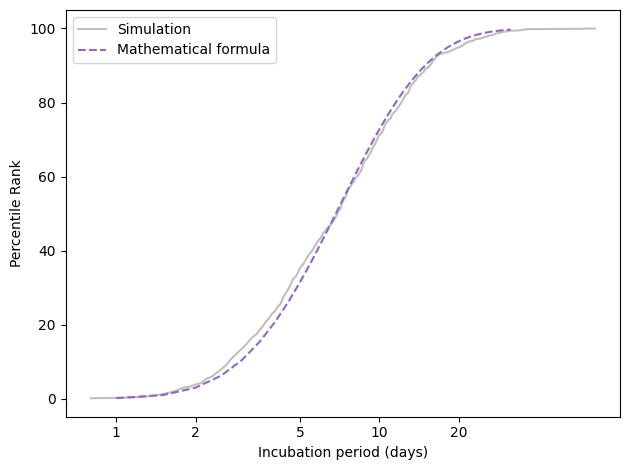

<IPython.core.display.Javascript object>

In [30]:
rows = 1155
cols = 1000
np.random.seed(18)

rvs = np.random.uniform(-2, 2, size=(rows, cols))
start = np.random.uniform(1, 10, rows)
thresh = np.random.normal(100, 10, rows)
sim_latency = simulate_latency(start, thresh, *res.x)
log_sim = np.log10(sim_latency)
cdf_sim = Cdf.from_seq(log_sim) * 100
cdf_sim.plot(color="gray", alpha=0.5, label="Simulation")

cdf_cn = make_conj_normal(*res2.x)
cdf_log_cn = Cdf(cdf_cn.transform(np.log10) * 100)
oob = (cdf_log_cn.qs < 0) | (cdf_log_cn.qs > 1.5)
cdf_log_cn[oob] = np.nan
cdf_log_cn.plot(color="C4", ls="--", label="Mathematical formula")

# cdf_latency.plot(ls="--", label="Data")
# make_plot(np.log10(latency_jitter))

labels = [1, 2, 5, 10, 20]
ticks = np.log10(labels)
plt.xticks(ticks, labels)
decorate(xlabel="Incubation period (days)", ylabel="Percentile Rank")

The formula is based on some approximations, so it doesn't predict the simulation results exactly, but it is close.
These results suggest that the distribution of incubation times is not actually lognormal, but tends to be approximately lognormal in practice.

We can use a similar model to explain the distribution of survival times for cancer patients.

## Why are survival times lognormal (sort of)?

In 2001 Patrick Royston, a researcher at University College, London, observed that the distribution of survival time after a cancer diagnosis often follows a lognormal distribution.
As examples, he used survival times for ovarian and breast cancers.
I will replicate his analysis using data for glioblastoma, a kind of brain cancer.

So why should cancer survival times tend to follow a lognormal distribution?
To answer that, let me propose a simple model for how cancers grow and cause disease.

Most cancers start with a single cell that mutates in a way that causes it to reproduce excessively.
A cancer might grow quickly during some intervals, more slowly during other intervals, and possibly shrink sometimes.
If at some point it grows large enough to be detected or cause symptoms, that's when it gets diagnosed.

After that point, it might continue to grow or, possibly in response to treatment, start to shrink.
Either way, it is likely that the growth rate varies over time.
If the treatment is not successful, the cancer might grow until it reaches some threshold where it causes death.

This model of cancer growth is identical to the model of infectious disease in the previous section.
So, for the same reasons, we expect the distribution of tumor size to be lognormal when observed at some time after diagnosis, and the time to reach some size threshold to be approximately lognormal.

This model applies even if there is variation between patients in the size of the cancer at the point of diagnosis, in the distribution of growth rates, and in the threshold where the cancer causes death.

However, it only applies if survival time after diagnosis is long enough for the Central Limit Theorem to apply, so that might explain why some of the shortest survival times deviate from the model.

So, this model might explain why the distribution of survival times is often lognormal, at least appoximately.

In his report, Royston presents practical reasons why the lognormal model is useful for describing and predicting survival times.
But there's another reason we might care about the shape of this distribution: it has a surprising and counterintuitive property that every cancer patient should know about.

To explain what it is, let me start with a distribution that behaves as we expect, the lifetimes of light bulbs.
We'll come back to cancer patients, and then move on to babies.

That said, another thing that is apparent from the figure is that the CDF on a log scale resembles the sigmoid shape of a Gaussian distribution, which suggests that survival times follow a lognormal distribution.
The following figure shows the survival curve again compared to the survival curve of a lognormal distribution.

In [31]:
DATA_PATH = "https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/data/"
filename = "brain.hdf"
download(DATA_PATH + filename)

<IPython.core.display.Javascript object>

In [32]:
brain = pd.read_hdf("brain.hdf", "brain")
brain.shape

(16202, 2)

<IPython.core.display.Javascript object>

In [33]:
brain.head()

,duration,observed
0,4.50,True
1,15.75,True
2,10.75,True
3,6.25,True
4,29.50,True


<IPython.core.display.Javascript object>

In [34]:
duration = brain["duration"]
duration.describe()

count    16202.000000
mean        13.457783
std         19.088951
min          0.250000
25%          3.250000
50%          7.750000
75%         16.500000
max        201.750000
Name: duration, dtype: float64

<IPython.core.display.Javascript object>

In [35]:
observed = brain["observed"]
observed.sum()

14548

<IPython.core.display.Javascript object>

In [36]:
import lifelines
from empiricaldist import Surv


def km_fit(duration, observed):
    """Compute a survival function by Kaplan-Meier estimation.

    duration: sequence of durations for complete and incomplete cases
    observed: sequence booleans indicating whether each case is complete

    returns: tuple of Surv (estimate, low, high)
    """
    fit = lifelines.KaplanMeierFitter().fit(duration, observed)
    surv_km = Surv(fit.survival_function_["KM_estimate"])

    ci_fit = fit.confidence_interval_
    surv_low = Surv(ci_fit["KM_estimate_lower_0.95"])
    surv_high = Surv(ci_fit["KM_estimate_upper_0.95"])

    return surv_km, surv_low, surv_high

<IPython.core.display.Javascript object>

In [37]:
surv_km, surv_low, surv_high = km_fit(duration, observed)
surv_km.drop(0, inplace=True)
surv_low.drop(0, inplace=True)
surv_high.drop(0, inplace=True)

<IPython.core.display.Javascript object>

In [38]:
surv_km.inverse(0.5), surv_km(24)

(array(8.5), array(0.16368232))

<IPython.core.display.Javascript object>

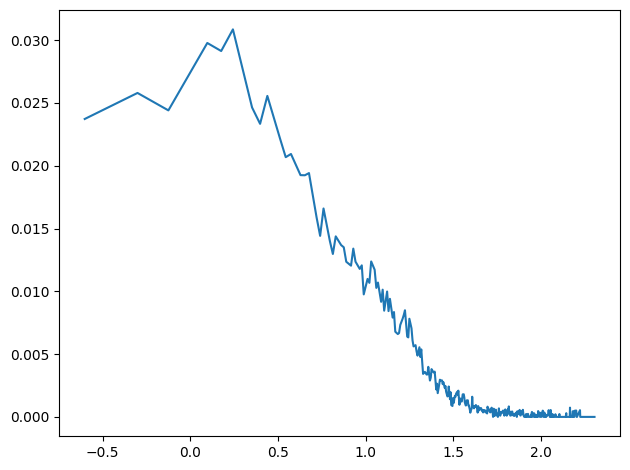

<IPython.core.display.Javascript object>

In [39]:
qs = np.log10(surv_km.qs)
ps = surv_km.ps

pmf = Surv(ps, qs).make_pmf()
pmf.normalize()
pmf.plot()
decorate()

In [40]:
mu, sigma = pmf.mean(), pmf.std()
mu, sigma

(0.8498778478744154, 0.5508581497702804)

<IPython.core.display.Javascript object>

In [41]:
def plot_fit(surv_km, surv_low, surv_high, **options):
    """Plot an estimated survival curve with error bounds.

    surv_km: estimated Surv
    surv_low, surv_high: lower and upper bounds
    options: passed to Series.plot
    """
    xs = surv_low.index
    plt.fill_between(xs, surv_low, surv_high, color="gray", alpha=0.3)
    surv_km.plot(**options)

<IPython.core.display.Javascript object>

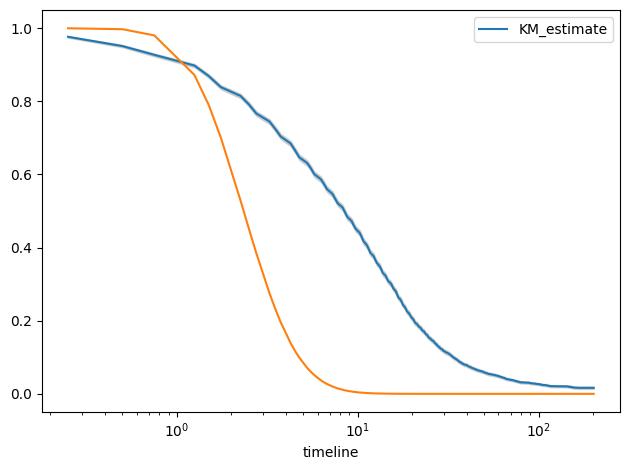

<IPython.core.display.Javascript object>

In [42]:
plot_fit(surv_km, surv_low, surv_high)

xs = surv_km.index
ps = norm.sf(np.log(xs), mu, sigma)
plt.plot(xs, ps)

decorate(xscale="log")

In [43]:
from scipy.optimize import least_squares


def fit_lognormal(surv, xs=None):
    """Fit a lognormal distribution to a survival function.

    surv: Surv object
    xs: places to evaluate the survival function

    returns: Surv
    """

    def error_func(params):
        mu, sigma = params
        # just fit over the range from 0 to 120 months
        xs = np.logspace(0, np.log10(120))

        ps = norm.sf(np.log(xs), mu, sigma)
        error = ps - surv_km(xs)
        return error

    pmf = surv.make_pmf()
    pmf.normalize()
    params = pmf.mean(), pmf.std()
    res = least_squares(error_func, x0=params, xtol=1e-3)
    assert res.success
    mu, sigma = res.x

    xs = surv.index if xs is None else xs
    ps = norm.sf(np.log(xs), mu, sigma)
    return Surv(ps, xs)

<IPython.core.display.Javascript object>

In [44]:
surv_lognormal = fit_lognormal(surv_km)
pmf_lognormal = surv_lognormal.make_pmf()

<IPython.core.display.Javascript object>

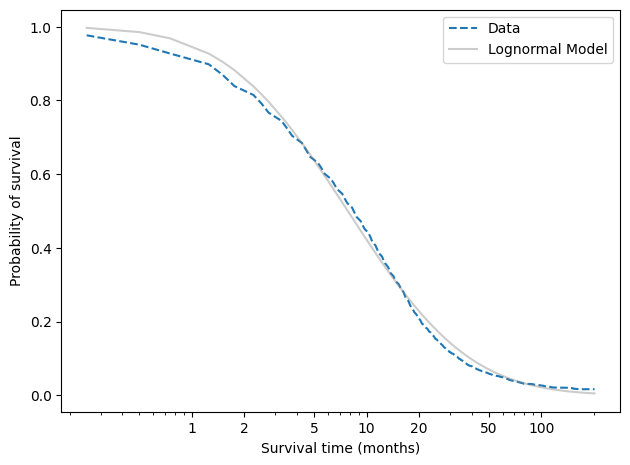

<IPython.core.display.Javascript object>

In [45]:
surv_km.plot(ls="--", label="Data")

surv_lognormal.plot(color="gray", alpha=0.4, label="Lognormal Model")

decorate(
    xlabel="Survival time (months)", ylabel="Probability of survival", xscale="log"
)
labels = [1, 2, 5, 10, 20, 50, 100]
ticks = labels
plt.xticks(ticks, labels)
None

The model fits the data well, although there is a discrepancy prior to 2 months of survival.

## Sources and Related Reading

* McAloon et al, ["Incubation period of COVID-19: a rapid systematic review and meta-analysis of observational research"](https://bmjopen.bmj.com/content/10/8/e039652).

* Royston, ["The Lognormal Distribution as a Model for Survival Time in Cancer, With an Emphasis on Prognostic Factors"](https://onlinelibrary.wiley.com/doi/10.1111/1467-9574.00158)

* The most boring experiment in the history of science is the pitch drop experiment. https://en.wikipedia.org/wiki/Pitch_drop_experiment

